<a href="https://colab.research.google.com/github/HEXNANO69/CheckList/blob/main/Full_Model_Stock_Prediction_%2B_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU Available?

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12167348947992985430
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17242160750792632982
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Data Pulling

In [10]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [11]:
#This part linkes the dataset in the drive to the google colab file
link = 'https://drive.google.com/file/d/1GcjfPLBNwpf7h2ngSx7yc6quFqXjvxiz/view?usp=drive_link'
id = link.split('/')[-2]
downloaded = drive.CreateFile({'id' : id})
downloaded.GetContentFile('StockPrices.csv')

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('StockPrices.csv')
df['Date']= pd.to_datetime(df['Date'])
df_close = df[['Date', 'Index', 'Close']]
df_close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15087 entries, 0 to 15086
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    15087 non-null  datetime64[ns]
 1   Index   15087 non-null  object        
 2   Close   15087 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 353.7+ KB


## Stock Prices

In [13]:
df_close = df_close.pivot_table(index = 'Date',columns = 'Index').dropna(axis = 'columns')

In [14]:
df_close #Removal of Unneccessary Stocks

Close                        
Index             AAPL        AMZN        GOOG
Date                                          
2005-02-28    1.602143    1.759000    4.682200
2005-03-01    1.589286    1.769500    4.634130
2005-03-02    1.575714    1.775000    4.612212
2005-03-03    1.492500    1.782500    4.657791
2005-03-04    1.528929    1.792500    4.630145
...                ...         ...         ...
2025-02-14  244.600006  228.679993  186.869995
2025-02-18  244.470001  226.649994  185.800003
2025-02-19  244.869995  226.630005  187.130005
2025-02-20  245.830002  222.880005  186.639999
2025-02-21  245.550003  216.580002  181.580002

[5029 rows x 3 columns]

In [15]:
#Saving Trading Days
dates = df_close.index

#Saving Stocks
stocks = df_close.droplevel(0,1).columns

### Data Manipulation
- Training/Testing Data
- Scaling the data (MinMaxScaler)

### Training/ Validation/ Test Set + Scaling the Data

In [16]:
from sklearn.model_selection import train_test_split
#Division of data
# df_close = df_close.to_numpy()
array_train, array_test = train_test_split(df_close, shuffle = False)

In [17]:
array_train.shape

(3771, 3)

In [18]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array_train = scl.fit_transform(array_train)
array_test  = scl.fit_transform(array_test)

# LSTM Stock Prediction

### Model Approach

In [19]:
#Get the data and splits in input X and output Y, by spliting in lookback number of past days as input X
#and horizon number of coming days as Y.
def processData(data, lookback, horizon,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -lookback - horizon +1, jump):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+horizon)])
    return np.array(X),np.array(Y)

In [20]:
num_companies = df_close.shape[1]
lookback = 252 #How many days of the past can the model see
horizon = 30 #How many days into the future are we trying to predict

In [21]:
# Formation of lookback dataframes and forward dataframes for training, and testing dataset
# to calculate accuracy

X_test,y_test = processData(array_test,lookback,horizon,num_companies,horizon)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,lookback,horizon,num_companies)
y = np.array([list(x.ravel()) for x in y])

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=1)

In [22]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(2792, 252, 3)
(698, 252, 3)
(33, 252, 3)
(2792, 90)
(698, 90)
(33, 90)


### Training the LSTM

In [23]:
?LSTM

Object `LSTM` not found.


In [24]:
from keras.models import Sequential, load_model
from keras.layers import LSTM,Dense,Activation,Attention

#Model Architecture - Two LSTM layers with x neurons & y epochs
num_neurons_L1 = 600
num_neurons_L2 = 100
EPOCHS = 2

#Model
model = Sequential()

model.add(LSTM(num_neurons_L1,input_shape=(lookback,num_companies), return_sequences=True))
model.add(LSTM(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.add(Dense(horizon * num_companies))
#model.add(Attention(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
history = model.fit(X_train,y_train,epochs=EPOCHS,
                    validation_data=(X_validate,y_validate),
                    shuffle=True,batch_size=1, verbose=2)

Epoch 1/2
2792/2792 - 79s - 28ms/step - loss: 0.0028 - val_loss: 9.9489e-04
Epoch 2/2
2792/2792 - 82s - 29ms/step - loss: 0.0012 - val_loss: 0.0025


### Training loss

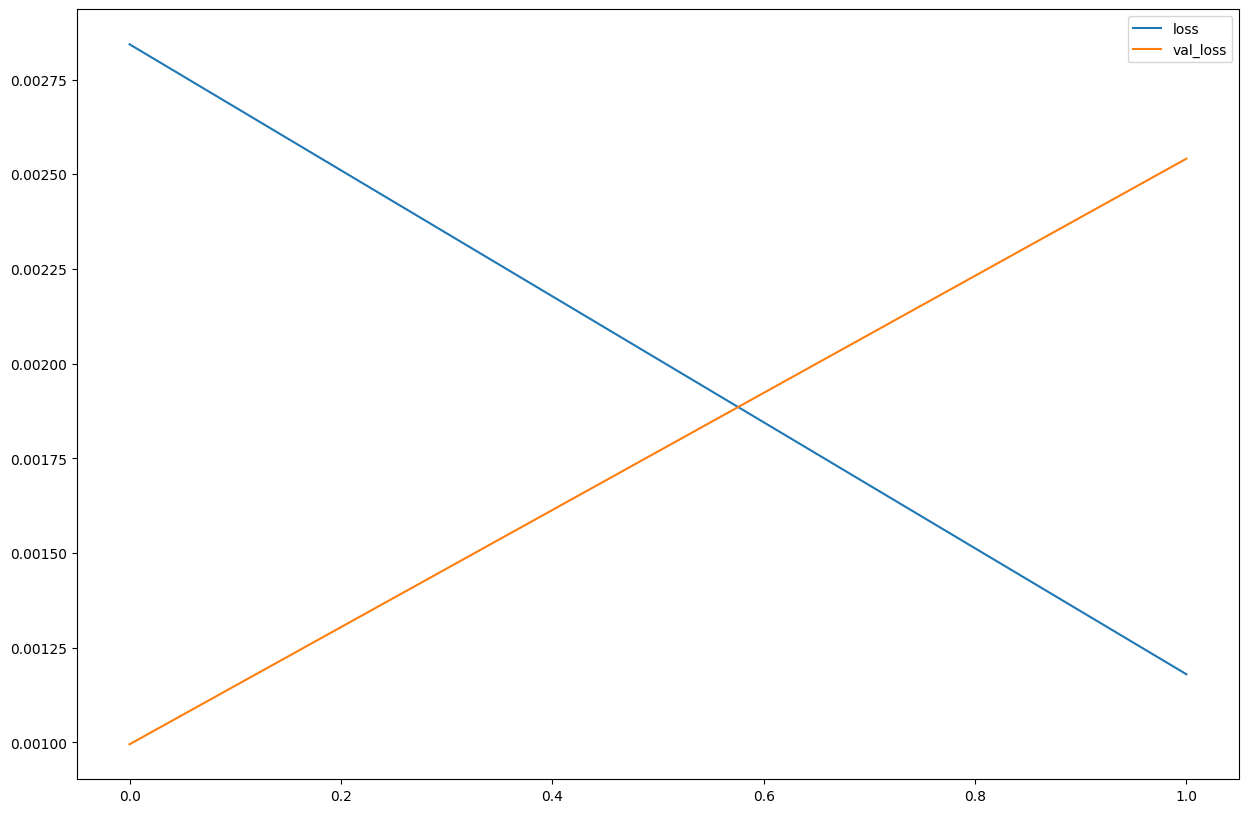

In [26]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

### Predicting Test Results

In [27]:
X_test,y_test = processData(array_test,lookback,horizon,num_companies,horizon)
y_test = np.array([list(a.ravel()) for a in y_test])

Xt = model.predict(X_test)
Xt.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


(33, 90)

### Un-scaling the data
Because the results were scaled to train the model, the output is non sensible until we return the data into its original form

In [28]:
def do_inverse_transform(output_result,num_companies):
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scl.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)

    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [29]:
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [30]:
Xt = do_inverse_transform(Xt, num_companies)
predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

(3, 33, 30)

In [31]:
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]

    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [32]:
Yt = do_inverse_transform(y_test, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(3, 990)

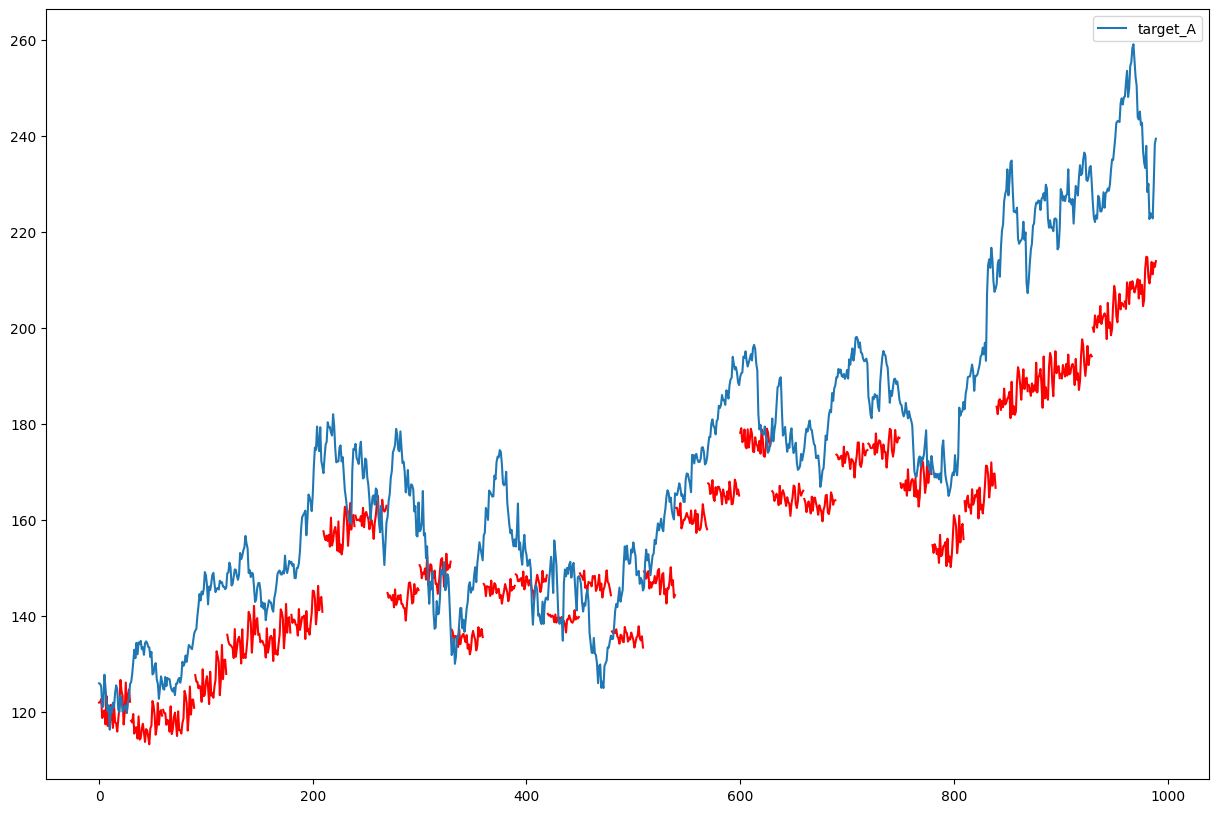

In [33]:
plt.figure(figsize = (15,10))

companies_to_show = [0] #select one of [0,1,2,3] to see only one
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'B', 'C', 'D']

for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    # plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label



for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [34]:
X_all,y_all = processData(scl.fit_transform(df_close),lookback,horizon,num_companies,horizon)
y_all = np.array([list(a.ravel()) for a in y_all])

In [35]:
Xt = model.predict(X_all)
Xt.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


(159, 90)

In [36]:
Xt = do_inverse_transform(Xt, num_companies)

predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape


(3, 159, 30)

In [37]:
Yt = do_inverse_transform(y_all, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(3, 4770)

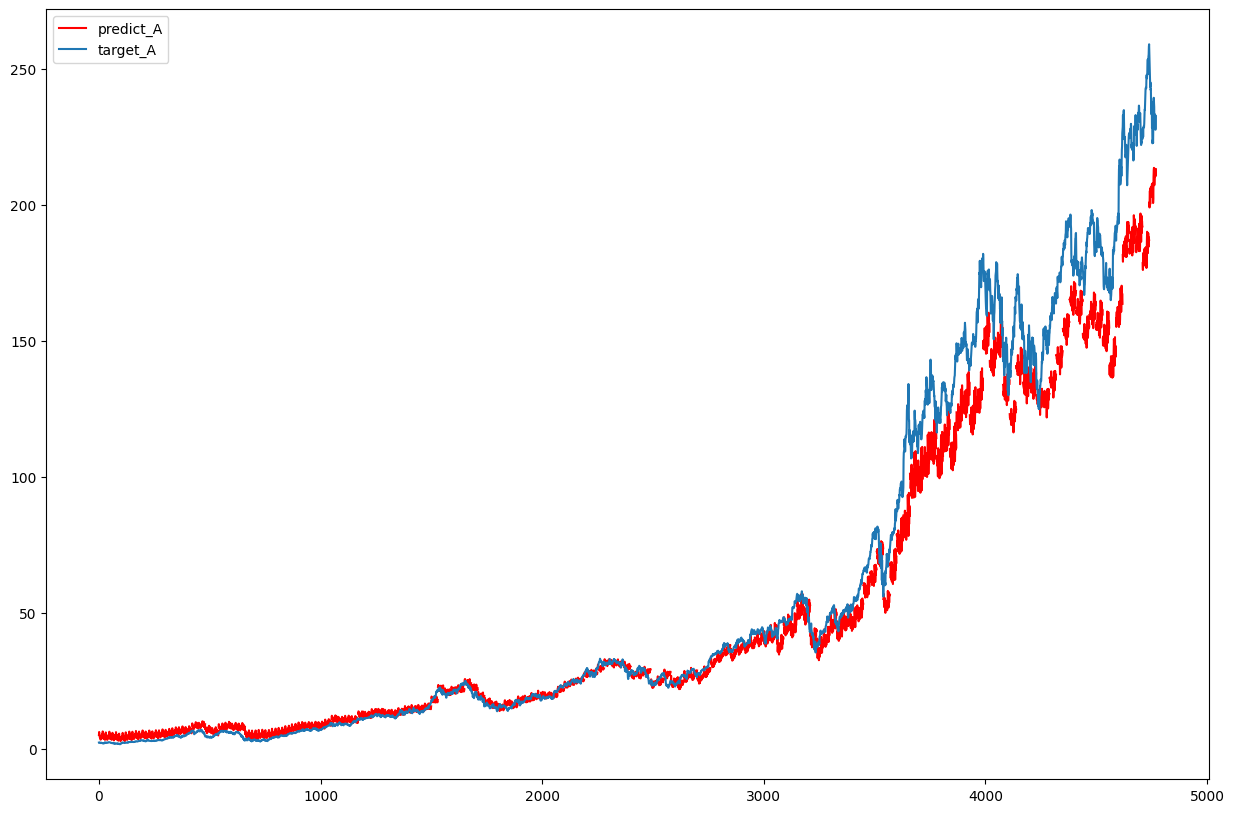

In [38]:
plt.figure(figsize = (15,10))

companies_to_show = [0]#select one of [0,1,2,3] to see only one
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'B', 'C', 'D']


for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label



for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [39]:
predicted_prices = np.zeros((predictions.shape[1]*predictions.shape[2],predictions.shape[0]))
# actual_prices = []

for i in range(predictions.shape[0]):
  counter = 0
  for j in range(predictions.shape[1]):
    for z in range(predictions.shape[2]):
      predicted_prices[counter, i] = predictions[i,j,z]
      counter+=1

print(counter)

4770


In [52]:
# Check shapes
print("Shape of predicted_prices:", predicted_prices.shape)
print("Shape of actuals.T:", actuals.T.shape)
print("Length of dates[lookback+5:]:", len(dates[lookback+5:]))

# Align shapes for predicted_prices
if predicted_prices.shape[0] < len(dates[lookback+5:]):
    dates_aligned_pred = dates[lookback+5:lookback+5+predicted_prices.shape[0]]
    predicted_prices = pd.DataFrame(data=predicted_prices, columns=stocks, index=dates_aligned_pred)
else:
    predicted_prices = predicted_prices[:len(dates[lookback+5:])]
    predicted_prices = pd.DataFrame(data=predicted_prices, columns=stocks, index=dates[lookback+5:])

# Align shapes for actual_prices
if actuals.T.shape[0] < len(dates[lookback+5:]):
    dates_aligned_actual = dates[lookback+5:lookback+5+actuals.T.shape[0]]
    actual_prices = pd.DataFrame(data=actuals.T, columns=stocks, index=dates_aligned_actual)
else:
    actuals_aligned = actuals.T[:len(dates[lookback+5:])]
    actual_prices = pd.DataFrame(data=actuals_aligned, columns=stocks, index=dates[lookback+5:])

# Check the final DataFrames
print("Predicted Prices:")
print(predicted_prices.head())

print("Actual Prices:")
print(actual_prices.head())

Shape of predicted_prices: (4772, 3)
Shape of actuals.T: (4770, 3)
Length of dates[lookback+5:]: 4772
Predicted Prices:
Index           AAPL      AMZN       GOOG
Date                                     
2006-03-07  5.238496  2.937300  11.916077
2006-03-08  6.321126  2.832592  11.257004
2006-03-09  5.212017  2.636986  10.900352
2006-03-10  5.018359  1.833776  10.164147
2006-03-13  4.362165  2.746668  10.225484
Actual Prices:
Index           AAPL    AMZN      GOOG
Date                                  
2006-03-07  2.446071  1.8720  9.031647
2006-03-08  2.467857  1.8560  9.085944
2006-03-09  2.486071  1.8440  9.376106
2006-03-10  2.418571  1.8605  9.419195
2006-03-13  2.338571  1.8430  9.168136


In [53]:
predicted_prices

Index,AAPL,AMZN,GOOG
Date,,,
2006-03-07,5.238496,2.937300,11.916077
2006-03-08,6.321126,2.832592,11.257004
2006-03-09,5.212017,2.636986,10.900352
2006-03-10,5.018359,1.833776,10.164147
2006-03-13,4.362165,2.746668,10.225484
...,...,...,...
2025-02-14,213.249710,201.026291,166.399734
2025-02-18,210.611450,206.529160,161.826752
2025-02-19,213.069595,209.215424,164.908890


In [54]:
actual_prices

Index,AAPL,AMZN,GOOG
Date,,,
2006-03-07,2.446071,1.872000,9.031647
2006-03-08,2.467857,1.856000,9.085944
2006-03-09,2.486071,1.844000,9.376106
2006-03-10,2.418571,1.860500,9.419195
2006-03-13,2.338571,1.843000,9.168136
...,...,...,...
2025-02-12,232.470001,236.169998,193.300003
2025-02-13,233.220001,238.830002,193.309998
2025-02-14,227.630005,229.149994,187.139999


# Changes we could make

- Add more neurons per layer or reduce layers
- Others?

# Next Steps
- Plug our data into scipy opt/ GD / Montecarlo to predict weights
- *Which performs better; historical mean returns or predicted stock prices?*

# Converting Prices to Returns

### Actual Returns
These are the actual stock returns that the market experienced

In [55]:
#Conversion of Actual Prices to Actual Returns
actual_returns = actual_prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:]  #Log returns minus first date
actual_returns

Index,AAPL,AMZN,GOOG
Date,,,
2006-03-08,0.008867,-0.008584,0.005994
2006-03-09,0.007353,-0.006486,0.031436
2006-03-10,-0.027527,0.008908,0.004585
2006-03-13,-0.033637,-0.009451,-0.027016
2006-03-14,0.012596,0.001897,-0.009965
...,...,...,...
2025-02-12,-0.001419,-0.024634,-0.071900
2025-02-13,0.003221,0.011200,0.000052
2025-02-14,-0.024261,-0.041375,-0.032438


### Predicted Returns
These are the stock returns that we predicted based on 252 days of prior trading days

In [56]:
from sklearn.impute import SimpleImputer

#Conversion of Predicted Prices to Returns
predicted_returns = predicted_prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:]  #Log returns minus first date

#Impute null rows with mean between rows
impute_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
predicted_returns = pd.DataFrame(data = impute_mean.fit_transform(predicted_returns),columns = stocks,index = dates[lookback+6:])

# predicted_returns = predicted_returns.dropna() #Dropping first row - cannot compute of T(0) without prior date stock price
predicted_returns

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index,AAPL,AMZN,GOOG
Date,,,
2006-03-08,0.187863,-0.036299,-0.056898
2006-03-09,-0.192930,-0.071556,-0.032195
2006-03-10,-0.037864,-0.363259,-0.069929
2006-03-13,-0.140134,0.404011,0.006016
2006-03-14,0.083749,0.035760,0.117836
...,...,...,...
2025-02-14,0.013711,-0.032565,0.019450
2025-02-18,-0.012449,0.027006,-0.027867
2025-02-19,0.011604,0.012923,0.018867


### Comparisons
Comparing the predicted returns(orange) to the actual returns(blue) for ADP


In [ ]:
plt.plot(predicted_returns['ADP'],alpha = .3)
plt.plot(actual_returns['ADP'],alpha = .5)
plt.show()

Comparing the predicted returns(orange) to the actual returns(blue) for AAPL

In [ ]:
plt.plot(predicted_returns['AAPL'],alpha = .3)
plt.plot(actual_returns['AAPL'],alpha = .5)
plt.show()

Heuristic for how 'accurately' the model predicts positive/negative returns over the course of the dataset

In [ ]:
temp1 = predicted_returns.to_numpy()
temp2 = actual_returns.to_numpy()

In [ ]:
correct_counter = 0
total = 0
for j in range(predicted_returns.shape[1]):
  stock = j
  for i in range(temp1.shape[0]):
    if(temp1[i,stock] >= 0 and temp2[i, stock] >=0):
      correct_counter+=1
      total+=1
    elif(temp1[i,stock] < 0 and temp2[i, stock] < 0):
      correct_counter+=1
      total+=1
    else:
      total+=1

In [ ]:
print("Correct: ", correct_counter)
print("Wrong: " , total-correct_counter)
print("%Correct ", correct_counter/total)

# Creation of subsamples

### Function

In [ ]:
from datetime import timedelta
from dateutil.parser import parse

def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and not y%400==0 else 28,31,30,31,30,31,31,30,31,30,31][m-1])
    new_date = (date.replace(day=d,month=m, year=y))
    return parse(new_date.strftime('%Y-%m-%d'))

def epochGenerator (dataframe, lookback, horizon,
                    step, cummulative = False):

#takes pandas dataframe with DatetimeIndex

    if cummulative:
        c = lookback
        step = horizon

    initial = min(dataframe.index)
    windows = []
    horizons = []

    while initial <= monthdelta(max(dataframe.index), -lookback):
        windowStart = initial
        windowEnd = monthdelta(windowStart, lookback)
        if cummulative:
            windowStart = min(dataframe.index)
            windowEnd = monthdelta(windowStart, c) + timedelta(days=1)
            c += horizon
        horizonStart = windowEnd + timedelta(days=1)
        horizonEnd = monthdelta(horizonStart, horizon)

        lookbackWindow = dataframe[windowStart:windowEnd]
        horizonWindow = dataframe[horizonStart:horizonEnd]

        windows.append(lookbackWindow)
        horizons.append(horizonWindow)

        initial = monthdelta(initial, step)

    return windows, horizons

### Subsamples by month for actual and predicted returns

In [ ]:
actual_windows, actual_horizons = epochGenerator(actual_returns, 12, 1, 1)
predicted_windows, predicted_horizons = epochGenerator(predicted_returns, 12,1,1)

In [ ]:
actual_windows[0].shape

# Stock Allocation: Scipy Optimize (Method 1)
- Aux functions (Mean Returns)
- Solving for portfolio weights

In [ ]:
#Mean Returns function
def mean_returns(df, length):
  mu = df.sum(axis = 0)/length
  return mu

### Optimizing for this predicted portfolio
- Using the predicted stock prices, what would be the optimal weight/ratio of the portfolio that would give the maximum return/minimal variance?

### Version for predicted stock prices

**Actual Returns**  
Actual returns signifies the returns that we would have actually generated based on the weights calculated with the *predicted stock prices*

**Predicted Returns**   
Predicted returns signifies the returns that we predict that we will generate based on the stock prices

**Why calculate predicted stock prices?**  
If the stock prices can be accurately predicted, we can anticipate which stocks will rise and decline - thus we can place a heavier weighting on the best performing stocks


In [ ]:
from scipy.optimize import minimize, Bounds, LinearConstraint
from numpy.linalg import norm

def actual_return(actual_returns, w):
  actual_returns = actual_returns
  mean_return = mean_returns(actual_returns, actual_returns.shape[0])
  actual_covariance = actual_returns.cov()

  portfolio_returns = mean_return.T.dot(w)
  portfolio_variance = w.T.dot(actual_covariance).dot(w)
  return portfolio_returns, portfolio_variance


#Input entire predicted returns df, starting date, and length to hold portfolio (forwards)
def optimize_weights(predicted_returns, actual_returns, lam1, lam2):
  mean_return = mean_returns(predicted_returns, predicted_returns.shape[0])
  predicted_covariance = predicted_returns.cov()

  #Cost Function
  def f(w):
    return -(mean_return.T.dot(w) - lam1*(w.T.dot(predicted_covariance).dot(w)) + lam2*norm(w, ord=1))

  #Bounds of Weights
  opt_bounds = Bounds(0, 1)

  #Equality Constraints
  def h(w):
    return sum(w) - 1

  #Constraints Dictionary
  cons = ({
      'type' : 'eq',
      'fun' : lambda w: h(w)
  })

  #Solver
  sol = minimize(f,
                 x0 = np.ones(mean_return.shape[0]),
                 constraints = cons,
                 bounds = opt_bounds,
                 options = {'disp': False},
                 tol=10e-10)


  #Predicted Results
  w = sol.x
  predicted_portfolio_returns = w.dot(mean_return)
  portfolio_STD = w.T.dot(predicted_covariance).dot(w)

  #Actual Results
  portfolio_actual_returns, portfolio_actual_variance = actual_return(actual_returns, w)

  ret_dict = {'weights' : w,
              'predicted_returns' : predicted_portfolio_returns,
              'predicted_variance' : portfolio_STD,
              'actual_returns' : portfolio_actual_returns,
              'actual_variance' : portfolio_actual_variance}

  return ret_dict

In [ ]:
act_rets = []
pred_rets = []
act_var  = []
pred_var = []

for i in range(20):
  opt = optimize_weights(predicted_horizons[i], actual_horizons[i], 0 , 0)
  act_rets.append(opt['actual_returns'])
  pred_rets.append(opt['predicted_returns'])
  act_var.append(opt['actual_variance'])
  pred_var.append(opt['predicted_variance'])
  print("Horizon", i)

In [ ]:
timestamps = []
for i in range(20):
  time = actual_horizons[i].index[0]
  timestamps.append(time)

act_rets = pd.DataFrame(data = act_rets, columns = ['Returns'], index=timestamps)
pred_rets = pd.DataFrame(data = pred_rets, columns = ['Returns'], index=timestamps)

## Diagnostics Plots

In [ ]:
diagnostics(act_rets, False)
diagnostics(pred_rets, True)

### Tangent Code: Version for non-predicted stock prices

In [ ]:
# from scipy.optimize import minimize, Bounds, LinearConstraint
# from numpy.linalg import norm

# #Input entire predicted returns df, starting date, and length to hold portfolio (forwards)
# def optimize_weights(predicted_returns, lam1, lam2, start, forwards):
#   predicted_returns = predicted_returns.iloc[start:start+forwards,:]
#   mean_return = mean_returns(predicted_returns, forwards)
#   predicted_covariance = predicted_returns.cov()

#   #Cost Function
#   def f(w):
#     return -(mean_return.T.dot(w) - lam1*(w.T.dot(predicted_covariance).dot(w)) + lam2*norm(w, ord=1))

#   #Bounds of Weights
#   opt_bounds = Bounds(0, 1)

#   #Equality Constraints
#   def h(w):
#     return sum(w) - 1

#   #Constraints Dictionary
#   cons = ({
#       'type' : 'eq',
#       'fun' : lambda w: h(w)
#   })

#   #Solver
#   sol = minimize(f,
#                  x0 = np.ones(mean_return.shape[0]),
#                  constraints = cons,
#                  bounds = opt_bounds,
#                  options = {'disp': False},
#                  tol=10e-10)


#   #Train Results
#   w = sol.x
#   portfolio_returns = w.dot(mean_return)
#   portfolio_STD = w.T.dot(predicted_covariance).dot(w)
#   return w

# w = optimize_weights(predicted_returns,.5, 1, 10, 30)


# def actual_return(actual_returns, w, start, forwards):
#   actual_returns = actual_returns.iloc
#   mean_return = mean_returns(actual_returns, forwards)
#   actual_covariance = actual_returns.cov()

#   portfolio_returns = mean_return.T.dot(w)
#   return portfolio_returns

### Performance
- Given $1000, how much would the portfolio grow/decline over 10+ years?
- How does this compare to investing in the S&P 500?

In [ ]:
# portfolio_value = 1000
starting_day = 500
last_day = 200
portfolio_values = [1000]
growth_list = []

for i in range(1,int(last_day/30)):
  w = optimize_weights(predicted_returns, .5, 100, starting_day, 30)
  growth = actual_return(actual_returns, w, starting_day, 30)
  print(" Month: ",  int(starting_day/30)+1, '/' , int(last_day/30))
  print("Growth: ", (1+growth))
  print()
  growth_list.append(growth)
  portfolio_values.append(portfolio_values[i-1] * (1+growth))
  starting_day += 30

In [ ]:
portfolio_values

# Stock Allocation: Montecarlo Simulation (Method 2)

In [ ]:
def Montecarlo(train_dataset):
  Rf = 0 #risk free
  n = 100000 # total portfolios
  np.random.seed(11304)
  W = np.zeros((n,len(train_dataset.columns))) #will store asset allocation for each of the portfolios
  Rp = np.zeros(n) #  will  store returns(daily) for each of the portfolios
  std = np.zeros(n) # will store std for each of the portfolios
  SR = np.zeros(n) # will store sharpe ratios for each of the portfolios
  for i in range(n):
      #w = np.random.random(382) #random weights for each of the stocks
      #w = w /np.sum(w)
      w = np.random.dirichlet(np.ones(382),size=1)

      w = w[0]
      W[i,:] = w # add to the asset allocation array
      Rp[i] = (train_dataset.mean().dot(w)).sum()
      std[i] = np.sqrt(np.dot(w.T, np.dot(train_dataset.cov(),w))) # 252 trading days
      SR[i] = (Rp[i]-Rf)/std[i]


  return {'Return of the Portfolio': Rp,
            'Standard Deviation': std,
            'Sharpe Ratio Achieved':SR,
            'Weights':W}

In [ ]:
n  = 10000
MC = Montecarlo(actual_windows[0])
SR_max = max(MC['Sharpe Ratio Achieved'])
max_index = np.where(MC['Sharpe Ratio Achieved'] == SR_max)
print("We randomly generated %d portfolios chosing different weigths for each of the 382 stocks."%n)
print("Out of those", n ,"portfolios, the most efficient one reached a Sharpe Ratio of", SR_max, ".")
print("It used the following asset allocation:")
print(MC['Return of the Portfolio'][max_index])

In [ ]:
actual_windows[0].mean()

In [ ]:
#-----------Intentionally Left Blank---------------#






































# Diagnostics Function for Above Code

Includes...
- Equity Graph: *How much money would we make using our techniques?*
- Drawbacks: *How much do we lose when our portfolio dips?*

In [ ]:
def diagnostics(returns, is_pred):
    if(is_pred == True):
      col = 'red'
    else:
      col = 'green'

    #Takes dataframe with DateIndex and Returns as only column

    #Add row for calculation purpose
    starting_point = pd.DataFrame([0], columns=['Returns'])
    equity = starting_point.append(returns)

    #-------------------Equity Graph-------------------#
    '''Lazy way of Calculating Equity Value -- refactor if time allows
    #Equity Val[t] = EquityVal[t-1] * (1 + returns[t])
    #Equity Val[t=0] = 100 '''
    returns_list = equity['Returns'].tolist()
    equities = [0] * len(equity)
    equities[0] = 100
    for i in range(1, len(returns_list)):
        equities[i] = equities[i-1] * (1 + returns_list[i])

    equity['Equity'] = equities
    equity.plot(y='Equity' , color = 'green')

    #---------------------Drawbacks---------------------#
    '''
    Measure of PAIN
    Drawback is the percentage loss from your previous all time high
    Drawback = -(PrevEQ_max - currEQ)/PrevEQ_max
    Note that most time a portfolio is in a drawdown
    What matters is how DEEP and how LONG until you are back up
    '''

    rolling_max = [0] * len(equities)
    for i in range(1, len(equities)):
        rolling_max[i] = max(equities[:i])

    drawbacks = [0] * len(equities)
    for i in range(1, len(equities)):
        drawbacks[i] = -(rolling_max[i] - equities[i])/rolling_max[i]

    #Always important to keep track of max Drawback i.e How deep
    max_Drawback = max(drawbacks)

    equity['Drawback'] = drawbacks
    equity.plot(y='Drawback')

# Paper Layout

### Data Manipulation
##### Data Gathering
- Calculate Returns(Discrete/Simple & Log Returns)
- Standardize log returns    

##### Train/Split
- [0+lookback : Last Day]
- Lookback = 1 year
- Hold = 1 month

### Base Models (Model 1)
- Montecarlo, Scipy optimize & Gradient Descent
- Optimize for min variance/Sharpe ratio
- Loss function derivation
- *Uses historical mean returns to predict the future*
- Inputs : Standarized log returns
- Outputs: Weights @each timestep

### Predicting Stock Prices (Model 1 extension)
- LSTM model to predict stock prices
- Normalizes stock prices
- Predict future prices
- Calculate returns as done previously (log returns)
- *The effectiveness of predicting the stock prices*
- LSTM Input: Standardized stock prices
- LSTM Output: Predicted Stock Prices
- Apply 3 base models & compare


